# Generating Marketing Case Study Data

This notebook is to create the data surrounding the marketing case study.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from faker import Faker
fake = Faker()

In [2]:
Nsamps = 100000 # number of purchases
Ncusts = 1500 # number of customers who made purchases
Nprods = 85 # number of products possible to buy

## Create the PURCHASE Table

### Generate Customer ID per Purchase

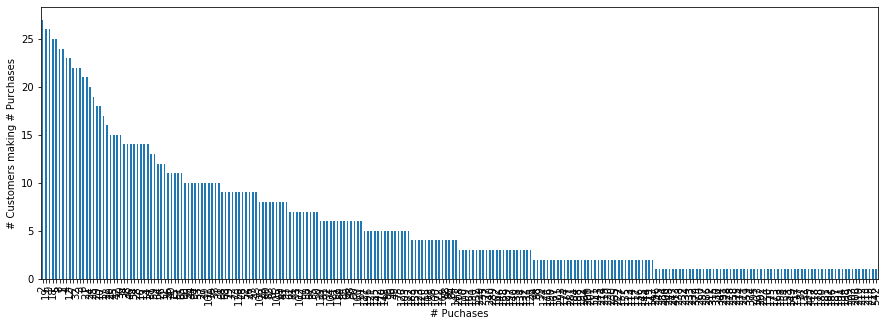

In [18]:
# Generate customer IDs for each purchase
np.random.seed(42)
p = np.random.exponential(scale=0.25, size = Ncusts)
p = p/p.sum()
purchase_cust_ids = pd.Series(np.random.choice(range(Ncusts), Nsamps, p = p), name = "CUST_ID")

# Inspect
purchase_cust_ids.value_counts().value_counts().plot(kind='bar', grid=False, figsize=(15,5))
plt.xlabel("# Puchases")
plt.ylabel("# Customers making # Purchases")
plt.show()

### Generate Product ID per Purchase

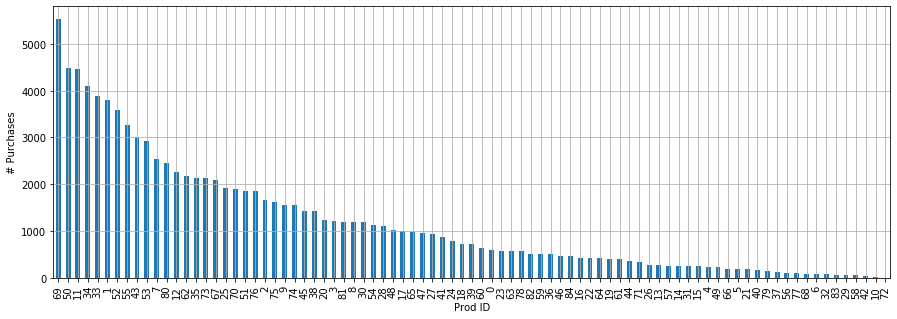

In [4]:
# Create purchased product IDs
np.random.seed(42)
p = np.random.exponential(scale=0.25, size = Nprods)
p = p/p.sum()
purchase_prod_ids = pd.Series(np.random.choice(range(Nprods), Nsamps, p = p), name = "PROD_ID")

# Inspect distribution
purchase_prod_ids.value_counts().plot(kind='bar', grid=True, figsize=(15,5))
plt.xlabel("Prod ID")
plt.ylabel("# Purchases")
plt.show()

### Generate Datetime of Purchase

In [5]:
# Date ranges will fall in 2018 and 2019
years = [2018,2019]
Faker.seed(42)
purchase_dates = pd.Series([fake.date_time_between_dates(pd.to_datetime(str(years[0])),
                                                         pd.to_datetime(str(years[-1]+1))) 
                            for _ in range(Nsamps)], name = "DATE")

### Concatenate the PURCHASE Table

In [6]:
purchase_table = pd.concat((purchase_dates,purchase_cust_ids,purchase_prod_ids), axis = 1).sort_values(by = "DATE").reset_index(drop=True)
purchase_table.sample(10).sort_index()

,DATE,CUST_ID,PROD_ID
1218,2018-01-09 14:22:52,140,69
3390,2018-01-25 10:16:45,43,43
14760,2018-04-18 14:13:14,313,62
37776,2018-10-05 05:48:14,873,53
41491,2018-10-31 21:38:36,127,80
49077,2018-12-25 03:45:26,707,33
50256,2019-01-02 22:19:10,1305,33
63501,2019-04-10 08:41:31,1447,80
70719,2019-06-01 03:03:28,1183,52
86153,2019-09-20 09:56:43,1425,53


In [7]:
purchase_table.groupby(['CUST_ID','PROD_ID']).size().value_counts()

1     22193
2      9280
3      4884
4      2655
5      1676
6       974
7       684
8       436
9       314
10      182
11      143
12      119
13       64
14       51
16       33
15       32
17       17
19       13
18       10
22        7
20        6
28        3
21        3
25        1
23        1
33        1
24        1
32        1
dtype: int64

## Create the CUSTOMER Table

In [8]:
np.random.seed(42)
Faker.seed(42)
# Pull out the customer IDs from the purchase table
cust_ids = pd.Series(purchase_cust_ids.unique(), name="CUST")
# Decide which states the customers live in
state_abrs, p = ["CA","AZ","OR","WA", "N\A"], [.5,.25,.1,.1,.05]
cust_states = pd.Series(np.random.choice(state_abrs, size = cust_ids.shape[0], p=p), name="STATE")
# Associate postal codes
def get_postalcode(sabr, null_val = "N\A"):
    try:
        return fake.postalcode_in_state(sabr)
    except:
        return null_val
cust_postalcode = pd.Series([get_postalcode(sabr) for sabr in cust_states], name="POSTAL")

In [9]:
customer_table = pd.concat((cust_ids, cust_states, cust_postalcode), axis = 1).sort_values(by = 'CUST').reset_index(drop=True)
customer_table.head()

,CUST,STATE,POSTAL
0,0,CA,93445
1,1,OR,97768
2,2,AZ,85837
3,3,AZ,86544
4,4,AZ,86533


In [10]:
customer_table.STATE.value_counts()

CA     728
AZ     374
WA     165
OR     136
N\A     77
Name: STATE, dtype: int64

## Create the PRODUCT Table

We will create quarterly prices per product. We will use wide table format and vary prices each quarter by a multiplicative factor $P(1+r)^q$ where $P$ is the initial price for the first quarter, $q$ is the count of number of quarters since the first quarter, and $r$ is a randomly generated normal with 1/100 as variance.

In [11]:
np.random.seed(42)
# Pull out the product IDs from the purchase table
prod_ids = pd.Series(purchase_prod_ids.unique(), name = "PROD")

# Create quarter labels in format 2018_Q1
quarters = sum([[str(yr)+"_"+q for q in ("Q1","Q2","Q3","Q4")] for yr in years],[])

# These are the r values in P(1+r)^q
price_deltas = np.random.randn(prod_ids.shape[0])/10

# Generate initial prices: P in P(1+r)^q
initial_prices = 100*np.random.exponential(size=prod_ids.shape[0]) + 1

# Calculate the prices throughout the quarters
prod_prices = pd.DataFrame(np.array([np.around(initial_prices*((1+price_deltas)**q),2)
                                      for q,_ in enumerate(quarters)]).T,
                            columns = quarters )

# Concatenate the product ids to the prices
prod_table = pd.concat((prod_ids,prod_prices), axis=1).sort_values(by = "PROD").reset_index(drop = True)
prod_table.head()

,PROD,2018_Q1,2018_Q2,2018_Q3,2018_Q4,2019_Q1,2019_Q2,2019_Q3,2019_Q4
0,0,181.36,192.46,204.23,216.72,229.98,244.05,258.97,274.81
1,1,56.71,45.86,37.08,29.99,24.25,19.61,15.86,12.82
2,2,239.89,208.02,180.40,156.44,135.66,117.64,102.02,88.47
3,3,26.68,26.19,25.70,25.22,24.76,24.30,23.84,23.40
4,4,15.79,17.38,19.12,21.04,23.15,25.48,28.03,30.85


## Save the tables as CSV

In [12]:
purchases_csv = 'data/purchases.csv'
customers_csv = 'data/customers.csv'
products_csv = 'data/products.csv'

In [15]:
import os
def safe_to_csv(df, fp, **kwargs):
    if os.path.exists(fp):
        ret = input(f'File {fp} already exists. Rewrite? (y or [n]): ')
        if not (str(ret).lower() in ['y','yes']):
            return fp
    kwargs.setdefault('index', False)
    df.to_csv(fp, **kwargs)
    return fp

saved_fps = []
for df, fp in [(purchase_table, purchases_csv), 
               (customer_table, customers_csv), 
               (prod_table, products_csv)]:
    saved_fps.append(safe_to_csv(df, fp))

File data/purchases.csv already exists. Rewrite? (y or [n]): y
File data/customers.csv already exists. Rewrite? (y or [n]): y
File data/products.csv already exists. Rewrite? (y or [n]): y


In [16]:
# Sanity/Quality check
for fp in saved_fps:
    print(f"For {fp}:")
    print(pd.read_csv(fp).head())
    print("")

For data/purchases.csv:
                  DATE  CUST_ID  PROD_ID
0  2018-01-01 00:10:36     1299        8
1  2018-01-01 00:39:56      418       34
2  2018-01-01 00:56:50     1110       34
3  2018-01-01 00:57:37     1360       67
4  2018-01-01 01:05:06      154       33

For data/customers.csv:
   CUST STATE POSTAL
0     0    CA  93445
1     1    OR  97768
2     2    AZ  85837
3     3    AZ  86544
4     4    AZ  86533

For data/products.csv:
   PROD  2018_Q1  2018_Q2  2018_Q3  2018_Q4  2019_Q1  2019_Q2  2019_Q3  \
0     0   181.36   192.46   204.23   216.72   229.98   244.05   258.97   
1     1    56.71    45.86    37.08    29.99    24.25    19.61    15.86   
2     2   239.89   208.02   180.40   156.44   135.66   117.64   102.02   
3     3    26.68    26.19    25.70    25.22    24.76    24.30    23.84   
4     4    15.79    17.38    19.12    21.04    23.15    25.48    28.03   

   2019_Q4  
0   274.81  
1    12.82  
2    88.47  
3    23.40  
4    30.85  



In [17]:
pd.read_csv("data/purchases.csv").tail()

,DATE,CUST_ID,PROD_ID
99995,2019-12-31 22:36:47,993,70
99996,2019-12-31 22:44:40,627,73
99997,2019-12-31 23:29:13,645,55
99998,2019-12-31 23:32:43,1464,69
99999,2019-12-31 23:41:28,825,76
